<a href="https://colab.research.google.com/github/sandalis05/Novelty-by-Newron/blob/main/Banana_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving Banana-Trainer.csv to Banana-Trainer.csv


In [4]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
%matplotlib inline
import csv
%cd /content/
import io
df2 = pd.read_csv(io.BytesIO(uploaded['Banana-Trainer.csv']))
# Dataset is now stored in a Pandas Dataframe
print(df2)

/content
              Name  Classes  bb_coord1  bb_coord2  bb_coord3  bb_coord4
0   Banana_001.jpg        1   0.258621   0.410920   0.212644   0.218391
1   Banana_002.jpg        1   0.149425   0.708333   0.264368   0.566092
2   Banana_003.jpg        1   0.387931   0.209770   0.419540   0.183908
3   Banana_004.jpg        1   0.281609   0.158046   0.143678   0.114943
4   Banana_005.jpg        1   0.349138   0.173851   0.267241   0.272989
5   Banana_006.jpg        1   0.248563   0.577586   0.307471   0.362069
6   Banana_007.jpg        1   0.489943   0.600575   0.192529   0.454023
7   Banana_008.jpg        1   0.255747   0.428161   0.465517   0.385057
8   Banana_009.jpg        1   0.829023   0.311782   0.112069   0.181034
9   Banana_010.jpg        1   0.691092   0.244253   0.244253   0.178161
10  Banana_011.jpg        1   0.127874   0.877874   0.250000   0.221264
11  Banana_012.jpg        1   0.790230   0.191092   0.275862   0.336207
12  Banana_013.jpg        1   0.451149   0.581897   0.2

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       45 non-null     object 
 1   Classes    45 non-null     int64  
 2   bb_coord1  45 non-null     float64
 3   bb_coord2  45 non-null     float64
 4   bb_coord3  45 non-null     float64
 5   bb_coord4  45 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.2+ KB


In [6]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: /device:GPU:0


In [7]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)
  
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                                ymin,
                                xmin,
                                ymax,
                                xmax,
                                color,
                                font,
                                thickness=4,
                                display_str_list=()):  
      draw = ImageDraw.Draw(image)
      im_width, im_height = image.size
      (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                    ymin * im_height, ymax * im_height)
      draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                  (left, top)],
                width=thickness,
                fill=color)
# If the total height of the display strings added to the top of the bounding
# box exceeds the top of the image, stack the strings below the bounding box
# instead of above.
      display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
# Each display_str has a top and bottom margin of 0.05x.
      total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

      if top > total_display_str_height:
        text_bottom = top
      else:
        text_bottom = top + total_display_str_height
      # Reverse list and print from bottom to top.
      for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                        fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

  
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmp9t7e3gy_.jpg.


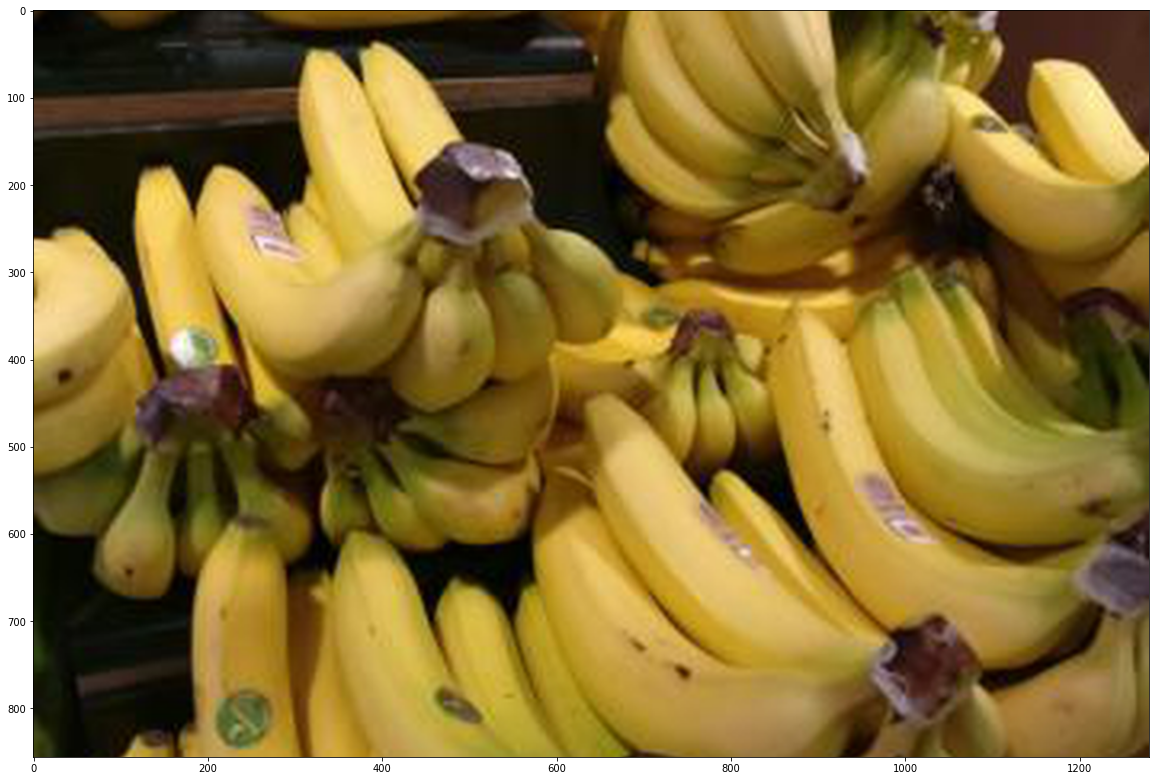

In [8]:
image_url = "https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/master/dataset/train/Fruit/Banana/Banana_001.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [9]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [11]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  57.30957293510437


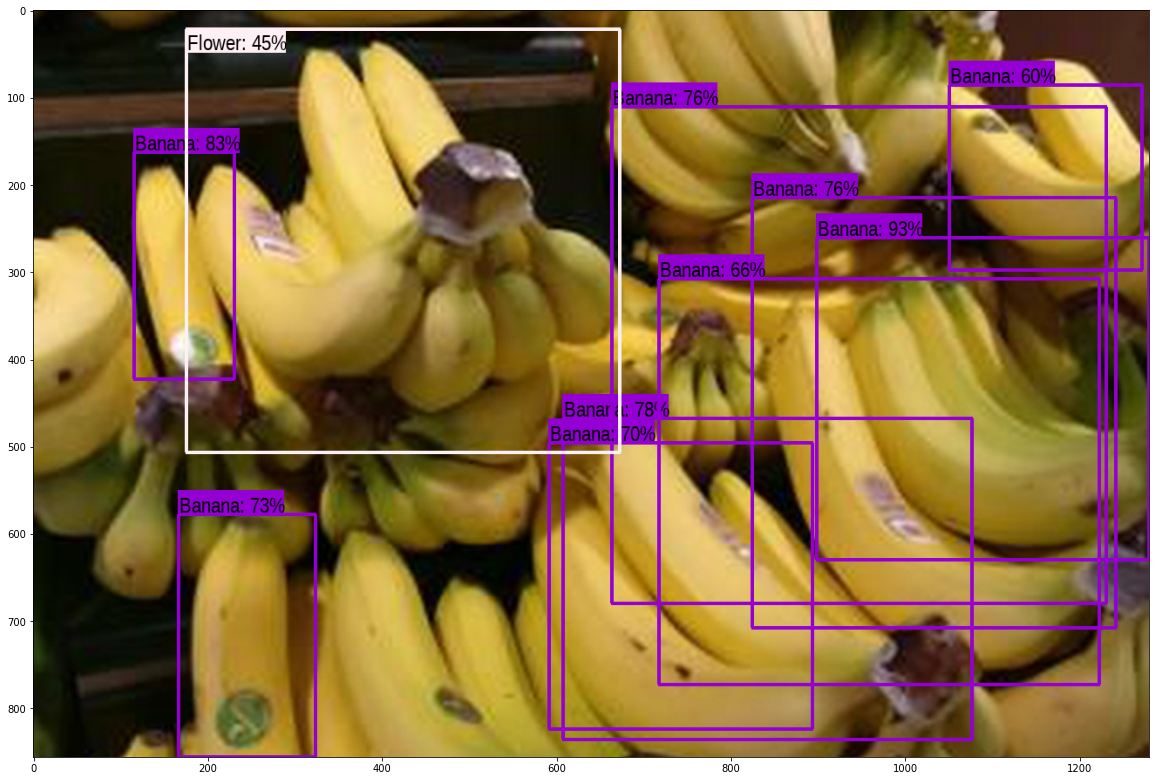

In [12]:
run_detector(detector, downloaded_image_path)

In [ ]:
bananapics = 